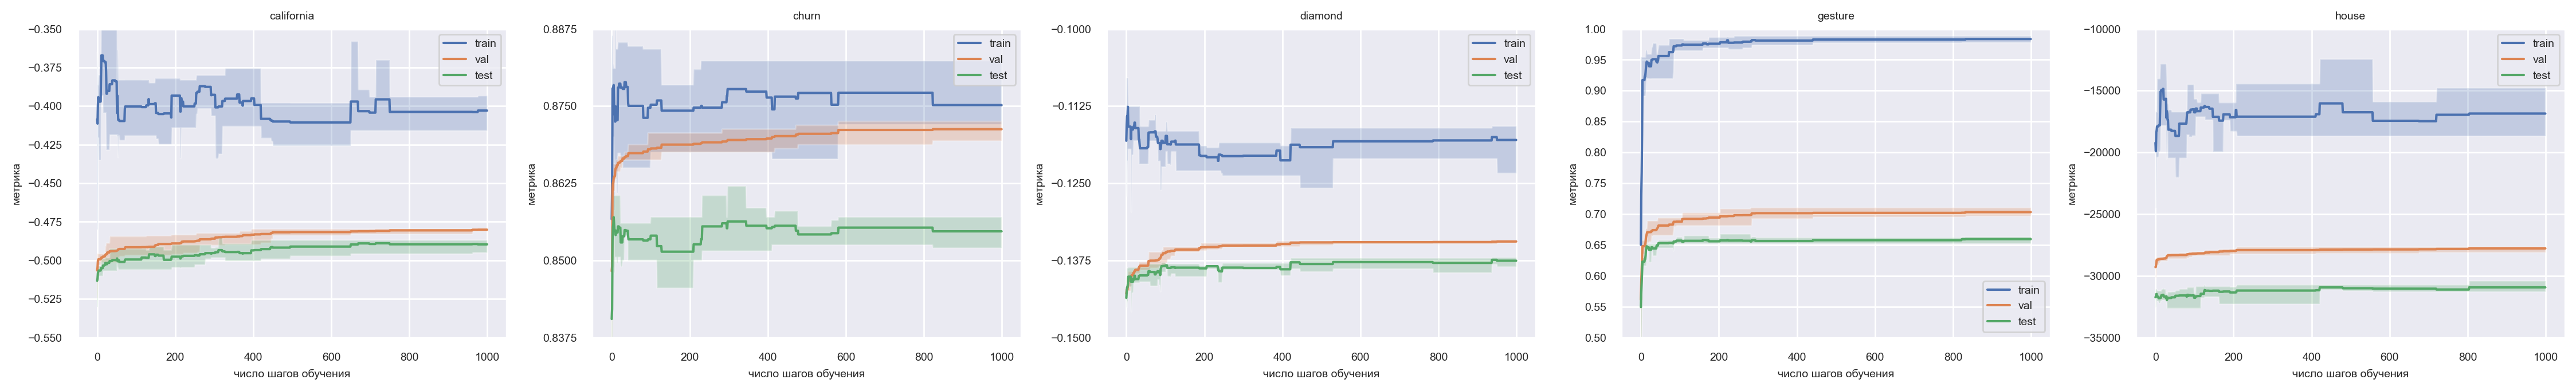

In [42]:
# !pip install torch
# !pip install -r ../requirements.txt
import sys
import os
os.environ['PROJECT_DIR'] = '/Users/timgritsaev/Desktop/tabular/tabular-hpo'
sys.path.append('/Users/timgritsaev/Desktop/tabular/tabular-hpo')
import lib
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp

import seaborn as sns
import numpy as np
%config InlineBackend.figure_format = 'retina'

sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 28, 3.5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
SMALL_SIZE = 7
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE) 
mlp.rcParams.update({"axes.grid" : True, "grid.color": "white"})
%matplotlib inline


def create_graphic_for_dataset(dataset_name, seeds_cnt, ax, x_ticks, y_ticks):
    train, val, test = None, None, None
    for i in range(seeds_cnt):
        study = torch.load('/Users/timgritsaev/Desktop/tabular/tabular-hpo/exp/mlp/' + dataset_name + '/' + str(i) + '-tuning/checkpoint.pt')
        tuning_steps_cnt = len(study['trial_reports'])

        train_scores = np.asarray([study['trial_reports'][j]['metrics']['train']['score'] for j in range(tuning_steps_cnt)])
        momentum_val_scores = np.asarray([study['trial_reports'][j]['metrics']['val']['score'] for j in range(tuning_steps_cnt)])
        momentum_test_scores = np.asarray([study['trial_reports'][j]['metrics']['test']['score'] for j in range(tuning_steps_cnt)])
        
        cumargmax = pd.Series(momentum_val_scores).expanding().apply(lambda x: x.argmax()).astype(np.int64)
        
        train = train_scores[cumargmax] if train is None else np.vstack([train, train_scores[cumargmax]])
        val = momentum_val_scores[cumargmax] if val is None else np.vstack([val, momentum_val_scores[cumargmax]])
        test = momentum_test_scores[cumargmax] if test is None else np.vstack([test, momentum_test_scores[cumargmax]])
        
    
    brightness = 0.25
    ax.plot(range(tuning_steps_cnt), np.mean(train, axis=0), label='train' )
    ax.fill_between(range(tuning_steps_cnt), np.min(train, axis=0), np.max(train, axis=0), alpha=brightness)
    
    ax.plot(range(tuning_steps_cnt), np.mean(val, axis=0), label='val' )
    ax.fill_between(range(tuning_steps_cnt), np.min(val, axis=0), np.max(val, axis=0), alpha=brightness)
    
    ax.plot(range(tuning_steps_cnt), np.mean(test, axis=0), label='test')
    ax.fill_between(range(tuning_steps_cnt), np.min(test, axis=0), np.max(test, axis=0), alpha=brightness)
    
    ax.set_title(dataset_name)
    
    ax.set_ylim(np.min(y_ticks), np.max(y_ticks))
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xlabel('число шагов обучения')
    ax.set_ylabel('метрика')
    ax.legend()
    

ds_names = ['california', 'churn', 'diamond', 'gesture', 'house']
ticks = {'california': [range(0, 1001, 200), np.arange(-0.55, -0.35, 0.025)],
         'churn': [range(0, 1001, 200), np.arange(0.8375, 0.9, 0.025 / 2)],
         'diamond': [range(0, 1001, 200), np.arange(-0.15, -0.1 + 0.01, 0.0125)],
         'gesture': [range(0, 1001, 200), np.arange(0.5, 1.001, 0.05)],
         'house': [range(0, 1001, 200), np.arange(-35000, -10000 + 1, 5000)]}

seeds_cnt = 5
fig, axs = plt.subplots(1, len(ds_names))
assert seeds_cnt > 1
for i in range(len(ds_names)):
    axs[i].grid()
    
    create_graphic_for_dataset(ds_names[i], seeds_cnt, axs[i], ticks[ds_names[i]][0], ticks[ds_names[i]][1])
    axs[i].grid()

plt.savefig("images/grokking-1")